In [57]:
import numpy as np
import pandas as pd

# import seaborn as sns
# import matplotlib.pyplot as plt

In [58]:
BASE_PATH = 'assets'
grp = pd.read_csv(f'{BASE_PATH}/food_group_mapping.csv').set_index('code').to_dict()['grup']
features_map = pd.read_csv(f'{BASE_PATH}/features_mapping.csv').set_index('Unnamed: 0').to_dict()['name']
hindi_name = pd.read_csv(f'{BASE_PATH}/hindi_name.csv').set_index('code').to_dict()['local_name']
gi_map = pd.read_csv(f'{BASE_PATH}/gi_mapping.csv').fillna('').set_index('code')['gi_values'].str.split('-').apply(lambda x:x[-1] if x[-1] else "-1").to_dict()

# 1.  PROXIMATE PRINCIPLES AND DIETARY FIBRE
## All values are expressed per 100g edible portion; All blank space in the table represent below detectable limit
def load_data(file_name):
    df = pd.read_csv(f'{BASE_PATH}/{file_name}.csv',index_col='code')
    df.columns = df.columns.map(features_map)
    df['group'] = df.index.map(grp)
    df['lang_hi'] = df.index.map(hindi_name)
    df['GI'] = df.index.map(gi_map)
    
    cat_cols = df.columns.difference(['Food Name','No. of Regions','group','lang_hi'])
    for col in cat_cols:
        
        df[col] = df[col].fillna("0").apply(lambda x: x.split("±")[0]).astype('float64')
    df.fillna('',inplace=True)
    with open(f'{BASE_PATH}/{file_name}.txt') as file:
        print(''.join(file.readlines()[9:]))  # Remove COPYRIGHT lines from the print 
    
    return df
        
# def calculate_uncertainty(mean, std = 0):
#     mean, std = float(mean), float(std)
#     lower_bound = mean - std
#     upper_bound = mean + std
#     return f"{lower_bound:.2f}", f"{upper_bound:.2f}"

# ## We can store the uncertainty into two seprate columns
# # df1['moisture[g]'].str.split("±").apply(lambda x: calculate_uncertainty(*x))

# def format_datatypes(cat_cols,df):
#     ## let's go ahead with the mean value
#     fill_values = {'object': '', 'float64': 0}
#     # Replace NaN values based on data type
#     for col in df.columns:
#         fill_value = fill_values.get(str('float64' if col not in cat_cols else "object"), 'object')
#         df[col] = df[col].fillna(fill_value)
#     return df

# def get_mean_value(df):
#     return df.fillna(0.0).applymap(str).applymap(lambda x: x.split("±")[0])


In [59]:
file_name = '01'

df = load_data(file_name)


# PROXIMATE PRINCIPLES AND DIETARY FIBRE
# (All values are expressed per 100g edible portion; All blank space in the table represent below detectable limit)
# - Food Code
# - Food Name
# - No. of Regions
# - Moisture [g]
# - Protein [g]
# - Ash [g]
# - Total Fat [g]
# + Dietary Fibre
#   - Total [g]
#   - Insoluble [g]
#   - Soluble [g]
# - Carbohydrate [g]
# - Energy [kJ]



In [60]:

def score_list(lst):
    total_sum = sum(lst)
    a, b, c = lst
    def calculated_score(a,b,c):
        a_score = a
        b_score = (100 - abs(50 - (b + 10)))/2 + (50 / (1 + np.exp(-((b + 10)-50)/5)))
        c_score = (1 / (c + 1)) * 1000      # inverse scale, higher the better
        return a_score +b_score+c_score
    
    total_score = calculated_score(a,b,c) + calculated_score( (a*100)/total_sum,(b*100)/total_sum,(c*100)/total_sum)
    return total_score

df['keto_score'] = df[['Total Fat', 'Protein', 'Carbohydrate']].apply(lambda x:score_list(x),axis=1)

In [61]:
def scale_values(values):
    min_val = min(values)
    max_val = max(values)
    scaled_values = [(x - min_val) / (max_val - min_val) for x in values]
    return scaled_values
df.keto_score = scale_values(df.keto_score) 
df.keto_score *= 100
df.keto_score = df.keto_score.round(3)


In [62]:
df.sort_values('keto_score',ascending=False)[["Food Name",'Total Fat', 'Protein', 'Carbohydrate','keto_score']]

,Food Name,Total Fat,Protein,Carbohydrate,keto_score
code,,,,,
O048,"Pork, shoulder",18.83,17.41,0.00,100.000
O050,"Pork, ham",18.55,18.83,0.00,99.994
P017,Hilsa (Tenualosa ilisha),18.49,21.80,0.00,99.954
M006,"Egg, poultry, yolk, boiled",27.46,16.13,0.00,99.882
S005,Pangas (Pangasianodon hypophthalmus),16.77,17.12,0.00,99.856
...,...,...,...,...,...
E057,"Raisins, dried, black (Vitis vinifera)",0.34,2.57,71.29,0.182
E018,"Dates, dry, dark brown (Phoenix dactylifera)",0.35,2.38,72.67,0.157
E019,"Dates, processed (Phoenix dactylifera)",0.41,1.18,67.95,0.140


In [63]:
groupwise_score_bucket = {}
[groupwise_score_bucket.update(dictionary) for dictionary in df.groupby('group').apply(lambda x: {k:v for k,v in zip(x.index, scale_values(x['keto_score']))}).values]
df['keto_score_per_group'] = df.index.map(groupwise_score_bucket)
df['keto_score_per_group'] *= 100
df.keto_score_per_group = df.keto_score_per_group.round(3)

In [64]:
import plotly.express as px
px.line(df.sort_values(['keto_score','Total Fat', 'Protein', 'Carbohydrate'],ascending=[False,False,False,True]) , y=['keto_score','Total Fat', 'Protein', 'Carbohydrate'])

## Algo Validation 

<Axes: >

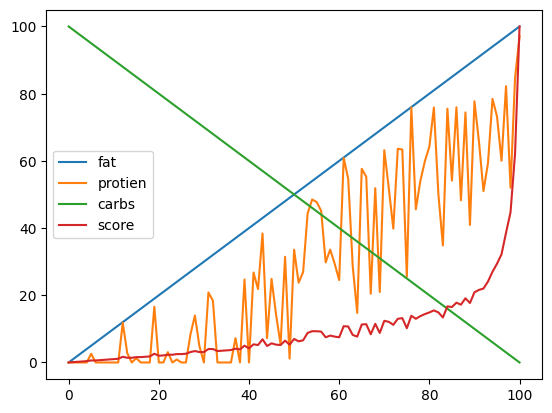

In [65]:
## Test Our Keto Score Calculation with some random synthetic data 
import random
random.seed(42)
test_rand = [(i,max(0,i+random.random()-random.randint(1,50)),100-i) for i in range(101)]
y_rand = np.round(scale_values([score_list(seq) for seq in test_rand]),3)
df_rand = pd.DataFrame(test_rand)
df_rand['score'] = y_rand
df_rand['score'] *= 100
df_rand.columns = ['fat','protien','carbs','score']
df_rand.plot()

## Dash App

# 

In [66]:

# df['image_path'] = [f"/assets/pics/{img}.jpeg" for img in df.index]
df['fiber2carb_ratio'] = (df['Dietary Fiber'] / df['Carbohydrate']).fillna(0.0).round(3)

In [67]:
import dash
from dash import dcc
from dash import html
import pandas as pd
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dash_table

# Define Dash app
app = JupyterDash(__name__)

# Define layout
app.layout = html.Div([
    html.H1('Nutritional Value Dash'),
    html.Label('Group'),
    dcc.Dropdown(
        id='group-dropdown',
        options=df['group'].unique(),
        value= ''
    ),
    html.Label('Food Name'),
    dcc.Dropdown(
        id='food-dropdown',
        options=df['Food Name'].unique(),
        value= ''
    ),
    dcc.Graph(id='box-plot'),
    html.Table(id='data-table', style={'width': '95%', 'margin': 'auto'}),
])


# Define callback for the box plot and table
@app.callback(
    [dash.dependencies.Output('box-plot', 'figure'),
     dash.dependencies.Output('data-table', 'children')],
    [dash.dependencies.Input('group-dropdown', 'value'),
     dash.dependencies.Input('food-dropdown', 'value')]
)


def update_fig_and_table(selected_group, selected_food, page_current=0, page_size=50):
    print(selected_group)
    if (not selected_food) and (not selected_group) :
        filtered_df = df
    else:
        filtered_df = df[(df['group'] == selected_group) | (df['Food Name'] == selected_food)].fillna(-1)
#     filtered_df['image_html'] = filtered_df['image_path'].apply(lambda x: f'<img src="{x}" width="100px">')
    sorted_df = filtered_df[['lang_hi', 'Food Name', 'Total Fat', 'Protein', 'Carbohydrate','fiber2carb_ratio', 'keto_score',"keto_score_per_group" ,'group']].sort_values(
        by=["keto_score",'Carbohydrate', 'Total Fat', 'Protein'],
        ascending=[False,True, False, False]
    )
    fig = px.box(filtered_df, y=['Total Fat', 'Protein', 'Carbohydrate','GI'],points="all",hover_data=['Food Name','lang_hi'])
    
    table = dash_table.DataTable(
        id='table',
        columns=[{'name': col, 'id': col} for col in sorted_df.columns],
        data=sorted_df.to_dict('records'),
        page_current=page_current,
        page_size=page_size,
        sort_action='native',  # Enable sorting
        sort_mode='multi',  # Enable multi-column sorting
        style_table={'width': '95%', 'margin': 'auto'},
        style_header={
            'backgroundColor': 'rgb(230, 230, 230)',
            'fontWeight': 'bold'
        },
    style_cell={
        'textAlign': 'left',
        'whiteSpace': 'normal',
        'height': 'auto',
    },
    )

    return fig, [table]

app.run_server(port=8052)

Dash is running on http://127.0.0.1:8052/

Dash app running on http://127.0.0.1:8052/

Cereals and Millets
Grain Legumes
Green Leafy Vegetables
Grain Legumes
Green Leafy Vegetables
Other Vegetables
Fruits
Roots and Tubers
Condiments and Spices
None
Nuts and Oil Seeds
Sugars
Mushrooms
Miscellaneous Foods
Milk and Milk Products
Egg and Egg Products
Poultry
Animal Meat
Poultry
Fresh Water Fish and Shellfish
None
Poultry
Poultry
